In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import RegularGridInterpolator

In [ ]:
def mua_melanin(x, mvf):
    return 519 * (x / 500) ** (-3.5) * mvf / 10  # /mm

In [3]:
df = pd.read_csv("cali_curve.csv", index_col=0)
df.set_index(["MVF", "WL"], inplace=True, drop=False)

df["Compare Fluence"] = np.exp(-mua_melanin(df["WL"], df["MVF"]) * 0.06)

for n, g in df.groupby(level=0):
    # print(df.loc[(0.02, ), "Fluence"])
    df.loc[(n,), "Normalised"] = (
        df.loc[(n,), "Fluence"].values / df.loc[(0.02,), "Fluence"].values
    )

In [4]:
wavelengths = df.index.get_level_values(1)[:5].values
mvf = df.index.get_level_values(0)[::5].values

In [5]:
norm_grid = -np.log(df["Normalised"].values.reshape((-1, 5)))

correction_factor_spline = RegularGridInterpolator(
    (wavelengths, mvf), norm_grid.T, method="cubic"
)
correction_factor_spline((880, 0.02))

array(0.)

In [6]:
mvf

array([0.02      , 0.03641128, 0.06628908, 0.12068353, 0.21971211,
       0.4       ])

# Apply the correction factor to blood spectra and make an sO2 curve

In [7]:
from patato.unmixing.spectra import SPECTRA_NAMES

In [8]:
hb_mua = SPECTRA_NAMES["Hb"].get_spectrum(wavelengths)
hbo2_mua = SPECTRA_NAMES["HbO2"].get_spectrum(wavelengths)

unmixer = np.linalg.pinv(np.stack([hb_mua, hbo2_mua]))

In [43]:
so2_0 = 0.847

In [ ]:
ita_eval = [27, 49]  # np.linspace(-45, 64.22, 100)


def mvf_calc(ita):
    return (19.028 - 0.3692 * ita + 0.001685 * ita**2) / 100


p0 = so2_0 * hbo2_mua + (1 - so2_0) * hb_mua

In [45]:
np.max(mvf), mvf_calc(-45)

(0.3999999999999999, 0.39054125)

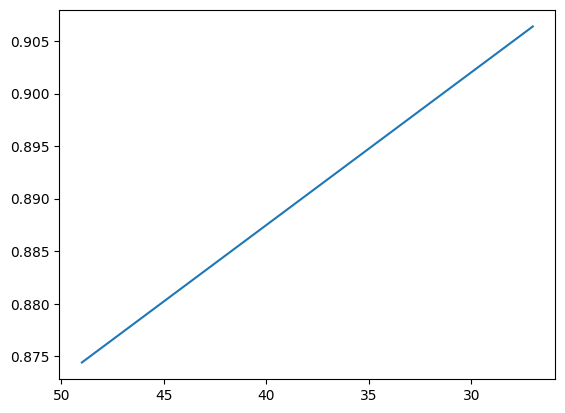

In [46]:
so2 = []
for ita in ita_eval:
    p1 = p0 * np.exp(-correction_factor_spline((wavelengths, mvf_calc(ita))))
    a, b = unmixer.T @ p1
    so2.append(b / (a + b))
plt.plot(ita_eval, so2)
plt.gca().invert_xaxis()
plt.show()

In [47]:
df = pd.DataFrame({"ita": ita_eval, "so2_model": so2})

In [48]:
# df.to_parquet("so2_model_fluence_bicep.parquet")

In [50]:
df.iloc[1] - df.iloc[0]

ita          22.000000
so2_model    -0.031955
dtype: float64